---
<center>

#  
# **Deep Learning - IBDA3311**
# Proyek UAS - Text Summarizer using Distilled Bart

Arion Ulibasa - **202001287**<br>
Halel Wahono - **191900496** <br>
Jason Caleb - **202001240**<br>
Jastin Suriono - **202000162** <br>
Victor Chendra - **202000338**<br>


</center>

---


# Dataset

In [ ]:
!pip install datasets evaluate rouge_score accelerate==0.20.3 transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=bc8adf7c12d6229453efa1545c391d056d2fe27ba70c58cf8c9fb58f25128c8d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive/text-summarization

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
import torch

dataset = load_dataset('ccdv/cnn_dailymail', '3.0.0', split={'train': 'train[:3000]', 'test': 'test[:1000]', 'validation': 'validation[:1000]'}, cache_dir='/content/dataset-cachedir')
dataset

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 1000
    })
})

In [ ]:
# Convert dataset to dataframe
import pandas as pd

# Convert each split to a Pandas DataFrame and add a "split" column
dataframes = {split_name: pd.DataFrame(split_data).assign(split=split_name) for split_name, split_data in dataset.items()}

# Concatenate the DataFrames
concatenated_df = pd.concat(dataframes.values(), keys=dataframes.keys())

# Add a new column "word_length" to each DataFrame
concatenated_df['article_length'] = concatenated_df['article'].apply(lambda x: len(x.split(" ")))
concatenated_df['highlightsarticle_length'] = concatenated_df['highlights'].apply(lambda x: len(x.split(" ")))

# Split dataframe
train_df = concatenated_df[concatenated_df["split"] == "train"]
test_df = concatenated_df[concatenated_df["split"] == "test"]
validation_df = concatenated_df[concatenated_df["split"] == "validation"]

# # Save to .csv
# train_df.to_csv("train_df.csv", index=False)
# test_df.to_csv("test_df.csv", index=False)
# validation_df.to_csv("validation_df.csv", index=False)

# Display
display(train_df.head(5))
display(test_df.head(5))
display(validation_df.head(5))

article  \
train 0  It's official: U.S. President Barack Obama wan...   
      1  (CNN) -- Usain Bolt rounded off the world cham...   
      2  Kansas City, Missouri (CNN) -- The General Ser...   
      3  Los Angeles (CNN) -- A medical doctor in Vanco...   
      4  (CNN) -- Police arrested another teen Thursday...   

                                                highlights  \
train 0  Syrian official: Obama climbed to the top of t...   
      1  Usain Bolt wins third gold of world championsh...   
      2  The employee in agency's Kansas City office is...   
      3  NEW: A Canadian doctor says she was part of a ...   
      4  Another arrest made in gang rape outside Calif...   

                                               id  split  article_length  \
train 0  0001d1afc246a7964130f43ae940af6bc6c57f01  train            1544   
      1  0002095e55fcbd3a2f366d9bf92a95433dc305ef  train             522   
      2  00027e965c8264c35cc1bc55556db388da82b07f  train            1013   
      3  0002c17436637c4fe1837c935c04de47adb18e9a  train             932   
      4  0003ad6ef0c37534f80b55b4235108024b407f0b  train             288   

         highlightsarticle_length  
train 0                        52  
      1                        29  
      2                        39  
      3                        50  
      4                        34

article  \
test 0  (CNN)James Best, best known for his portrayal ...   
     1  (CNN)The attorney for a suburban New York card...   
     2  (CNN)President Barack Obama took part in a rou...   
     3  Moscow (CNN)A Russian TV channel aired Hillary...   
     4  (CNN)Marco Rubio is all in.  The Republican se...   

                                               highlights  \
test 0  James Best, who played the sheriff on "The Duk...   
     1  A lawyer for Dr. Anthony Moschetto says the ch...   
     2  "No challenge poses more of a public threat th...   
     3  Presidential hopeful's video, featuring gay co...   
     4  Raul Reyes: In seeking Latino vote, Marco Rubi...   

                                              id split  article_length  \
test 0  00200e794fa41d3f7ce92cbf43e9fd4cd652bb09  test             467   
     1  0021fe8d65bd0d6d76d5fefba2ac02f0c48a43f4  test             496   
     2  0041698b4463a633f912681b96f73648cb012e33  test             958   
     3  0095ce085581314285f894af73a55ea9ef003412  test             431   
     4  00a51d5454f2ef7dbf4c53471223a27fb9c20681  test             793   

        highlightsarticle_length  
test 0                        31  
     1                        38  
     2                        27  
     3                        34  
     4                        42

article  \
validation 0  (CNN)Singer-songwriter David Crosby hit a jogg...   
           1  (CNN)Sigma Alpha Epsilon is under fire for a v...   
           2  (CNN)I'm Candida Moss and I am professor of Ne...   
           3  (CNN)Ferguson is crumbling. The cowardly and r...   
           4  Coral Gables, Florida (CNN)Former President Bi...   

                                                     highlights  \
validation 0  Accident happens in Santa Ynez, California, ne...   
           1  Sigma Alpha Epsilon is being tossed out by the...   
           2  Religion professor Candida Moss appears in eac...   
           3  Two police officers were shot Wednesday in Fer...   
           4  Clinton Foundation has taken money from foreig...   

                                                    id       split  \
validation 0  0044e296ecfe3ba57a351ad2a36d034491e878ce  validation   
           1  00716be72be8cf48cc23ac3b4b8924e569628be2  validation   
           2  00ac882e1a7f4862fa9f1e863b738966625f554d  validation   
           3  00c45eb98a06f9218170edf5767617cc20991840  validation   
           4  00dc77ce6c1d10bf1160829109b4f7d2a450823b  validation   

              article_length  highlightsarticle_length  
validation 0             207                        24  
           1             360                        28  
           2             878                        33  
           3             700                        17  
           4             758                        22

In [ ]:
def plot_dataset_distribution(data, split_):
    # a = "article_length" | "highlightsarticle_length"
    import matplotlib.pyplot as plt
    import seaborn as sns
    from statistics import mean, median

    figure, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
    figure.suptitle(f"Distribution of Word Lengths in {split_} dataset")

    # Given article lengths
    list_number1 = list(data["article_length"])
    list_number2 = list(data["highlightsarticle_length"])

    # Plotting Article
    plt.subplot(1, 2, 1)
    sns.kdeplot(list_number1, fill=True)
    plt.axvline(x=mean(list_number1), color='red', linestyle='--', label=f'Mean: {mean(list_number1): .2f}')
    plt.axvline(x=median(list_number1), color='green', linestyle='--', label=f'Median: {median(list_number1)}')
    plt.title('Article')
    plt.xlabel('Word Length')
    plt.ylabel('Number of Occurrences')
    plt.xlim(0, max(list_number1) + 100)
    plt.legend()

    # Plotting Summary
    plt.subplot(1, 2, 2)
    sns.kdeplot(list_number2, fill=True)
    plt.axvline(x=mean(list_number2), color='red', linestyle='--', label=f'Mean: {mean(list_number2): .2f}')
    plt.axvline(x=median(list_number2), color='green', linestyle='--', label=f'Median: {median(list_number2)}')
    plt.title('Summary')
    plt.xlabel('Word Length')
    plt.ylabel('Number of Occurrences')
    plt.xlim(0, max(list_number2) + 100)
    plt.legend()

    plt.show()

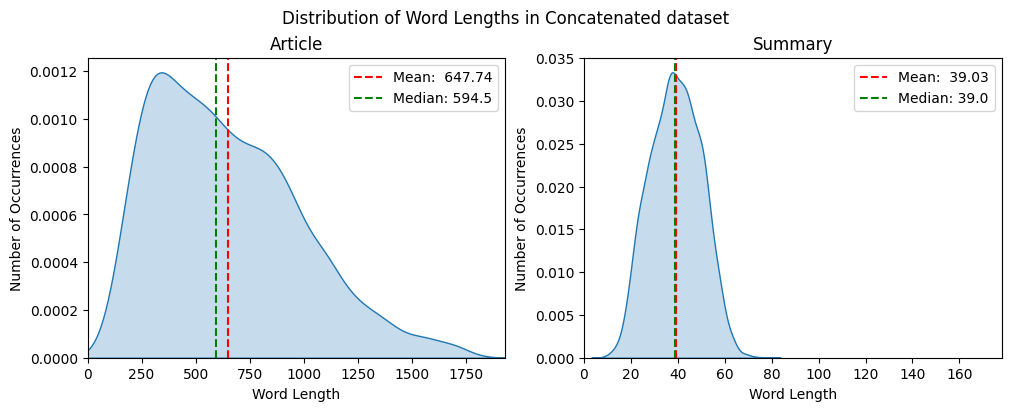

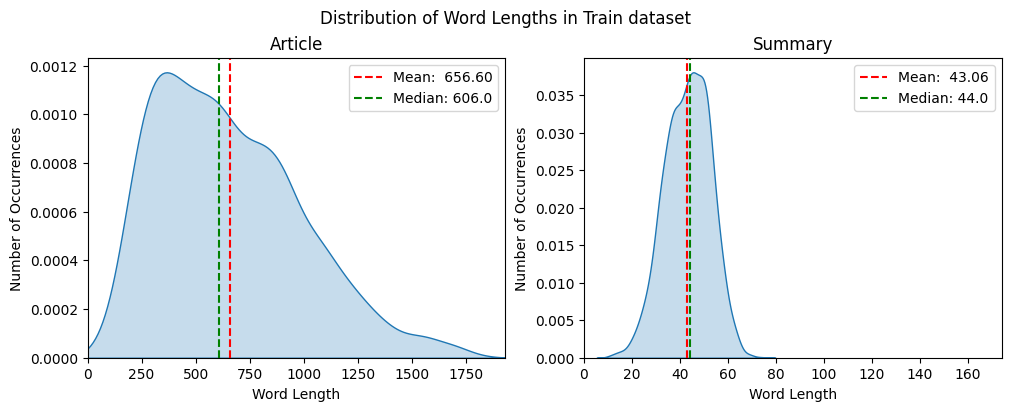

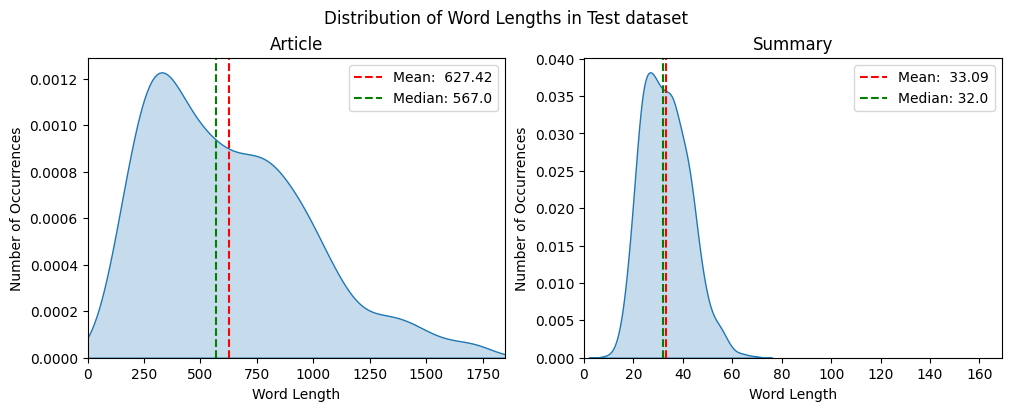

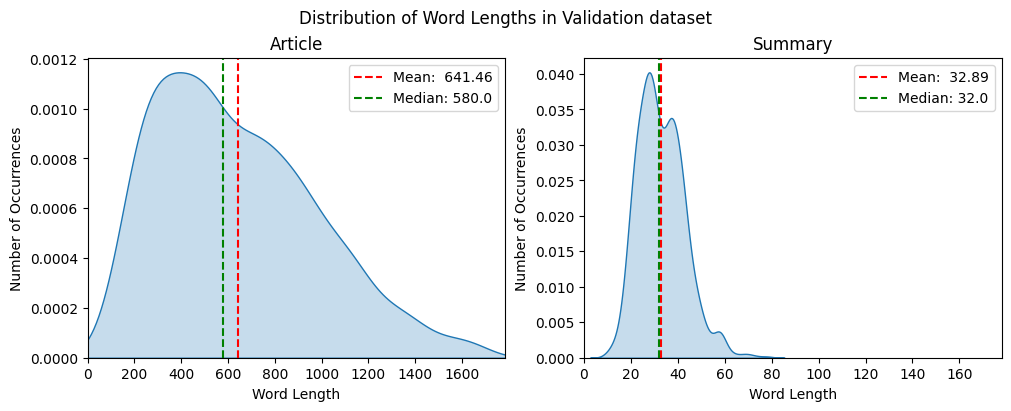

In [ ]:
plot_dataset_distribution(concatenated_df, "Concatenated")
plot_dataset_distribution(train_df, "Train")
plot_dataset_distribution(test_df, "Test")
plot_dataset_distribution(validation_df, "Validation")

# Preprocessing

In [ ]:
import re                                  # library for regular expression operations
import string                              # for string operations

import nltk
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

from transformers import AutoTokenizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

For the preprocessing, we decide to do it for the 'highlight' data or the target summary. This

In [ ]:
checkpoint = "sshleifer/distilbart-cnn-12-6"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
def preprocess(data):
    # Remove stock market tickers
    data["article"] = [re.sub(r'\$\w*','', article) for article in data["article"]]
    # Remove hyperlinks
    data["article"] = [re.sub(r'https?:\/\/.*[\r\n]*', '', article) for article in data["article"]]
    # Remove hashtags
    data["article"] = [re.sub(r'#', '', article) for article in data["article"]]

    # Tokenize the article
    article_tokens = [nltk.tokenize.word_tokenize(article) for article in data["article"]]

    # Remove stopwords and punctuation, and apply stemming
    stemmer = PorterStemmer()
    stopwordsEng = set(stopwords.words('english'))
    article_clean = [
        [stemmer.stem(word) for word in tokens if word.lower() not in stopwordsEng and word not in string.punctuation]
        for tokens in article_tokens
    ]

    # Tokenize words in an article
    joint_articles = [" ".join(cleaned_tokens) for cleaned_tokens in article_clean]

    inputs = tokenizer(joint_articles, return_tensors="pt", padding="max_length", truncation=True, max_length=1024)
    targets = tokenizer(data["highlights"], return_tensors="pt", padding="max_length", truncation=True, max_length=128)

    inputs["labels"] = targets["input_ids"]
    return inputs

In [ ]:
from datasets import DatasetDict

# Apply the preprocess function to the dataset
dptrain = dataset["train"].map(preprocess, batched=True)
dptest = dataset["test"].map(preprocess, batched=True)
dpvalidation = dataset["validation"].map(preprocess, batched=True)

# merge all Dataset into DatasetDict again
prepDataset = DatasetDict({
    'train': dptrain,
    'test': dptest,
    'validation': dpvalidation
})

# convert to torch, for the purpose of Trainer parameter
columns = ['input_ids', 'attention_mask', 'labels']
prepDataset.set_format(type="torch", columns=columns)
prepDataset

Parameter 'function'=<function preprocess at 0x7dbbbe38c5e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

# Model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Trainer, TrainingArguments

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [ ]:
import numpy as np
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from torch.utils.data import DataLoader

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
num_epochs = 4

# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    evaluation_strategy = "epoch",
    output_dir="./results",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    predict_with_generate=True,
    remove_unused_columns=False,
    fp16=True,
)

# Define the trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=training_args,
    train_dataset=prepDataset["train"],
    eval_dataset=prepDataset["test"],
    compute_metrics=compute_metrics
)
# Fine-tune the model
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.208500,0.920616,0.300400,0.096700,0.203800,0.276300,73.120000
2,0.820300,0.916116,0.304900,0.097100,0.206400,0.278800,74.454000
3,0.473000,1.006270,0.316100,0.101100,0.211500,0.288100,72.393000


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.208500,0.920616,0.300400,0.096700,0.203800,0.276300,73.120000
2,0.820300,0.916116,0.304900,0.097100,0.206400,0.278800,74.454000
3,0.473000,1.006270,0.316100,0.101100,0.211500,0.288100,72.393000
4,0.259700,1.116074,0.313000,0.096200,0.211100,0.285000,68.533000


TrainOutput(global_step=6000, training_loss=0.7923424250284831, metrics={'train_runtime': 7188.5336, 'train_samples_per_second': 1.669, 'train_steps_per_second': 0.835, 'total_flos': 1.8574945026048e+16, 'train_loss': 0.7923424250284831, 'epoch': 4.0})

**ROUGE-1:** Compares unigrams (single words) between the generated summary and the reference summary. The 'r' is the recall, 'p' is the precision, and 'f' is the F1-score, a harmonic mean of precision and recall.

**ROUGE-2:** Compares bigrams (pairs of consecutive words) between the generated and reference summaries.

**ROUGE-L:** Compares longest common subsequence between the two summaries.

In [ ]:
torch.save(model, f'/content/drive/MyDrive/text-summarization/ts-{num_epochs}.pth')

# Analysis

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
log_history = trainer.state.log_history
log_history

[{'loss': 2.3475, 'learning_rate': 4.96e-05, 'epoch': 0.33, 'step': 500},
 {'loss': 1.2648,
  'learning_rate': 4.54909090909091e-05,
  'epoch': 0.67,
  'step': 1000},
 {'loss': 1.2085,
  'learning_rate': 4.094545454545455e-05,
  'epoch': 1.0,
  'step': 1500},
 {'eval_loss': 0.9206163883209229,
  'eval_rouge1': 0.3004,
  'eval_rouge2': 0.0967,
  'eval_rougeL': 0.2038,
  'eval_rougeLsum': 0.2763,
  'eval_gen_len': 73.12,
  'eval_runtime': 894.4285,
  'eval_samples_per_second': 1.118,
  'eval_steps_per_second': 0.559,
  'epoch': 1.0,
  'step': 1500},
 {'loss': 0.8085,
  'learning_rate': 3.6400000000000004e-05,
  'epoch': 1.33,
  'step': 2000},
 {'loss': 0.8203,
  'learning_rate': 3.185454545454545e-05,
  'epoch': 1.67,
  'step': 2500},
 {'loss': 0.8203,
  'learning_rate': 2.7309090909090913e-05,
  'epoch': 2.0,
  'step': 3000},
 {'eval_loss': 0.9161156415939331,
  'eval_rouge1': 0.3049,
  'eval_rouge2': 0.0971,
  'eval_rougeL': 0.2064,
  'eval_rougeLsum': 0.2788,
  'eval_gen_len': 74.454,

Get the data after the training process

In [ ]:
# Extract loss values and epochs for training and evaluation separately
train_loss = [log['loss'] for log in log_history if 'loss' in log]
train_epochs = [log['epoch'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_epochs = [log['epoch'] for log in log_history if 'eval_loss' in log]
learning_rates = [log['learning_rate'] for log in log_history if 'learning_rate' in log]
steps = [log['step'] for log in log_history if 'learning_rate' in log]

Training vs Evaluation

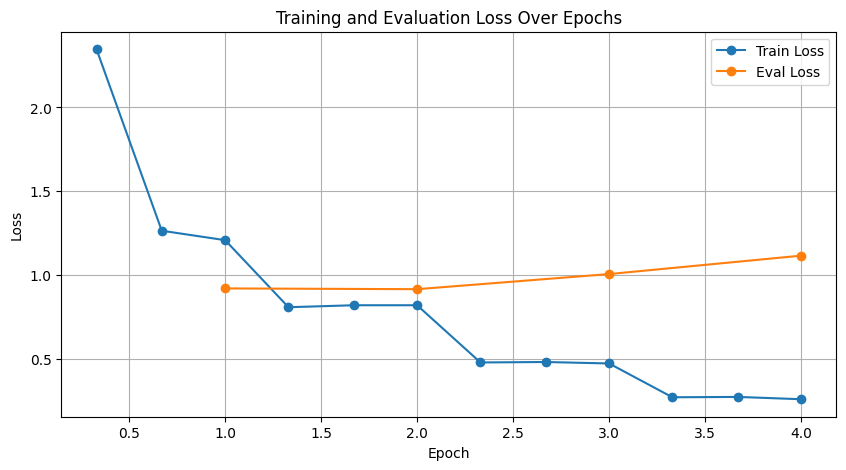

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label='Train Loss', marker='o')
plt.plot(eval_epochs, eval_loss, label='Eval Loss', marker='o')
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Learning Rate

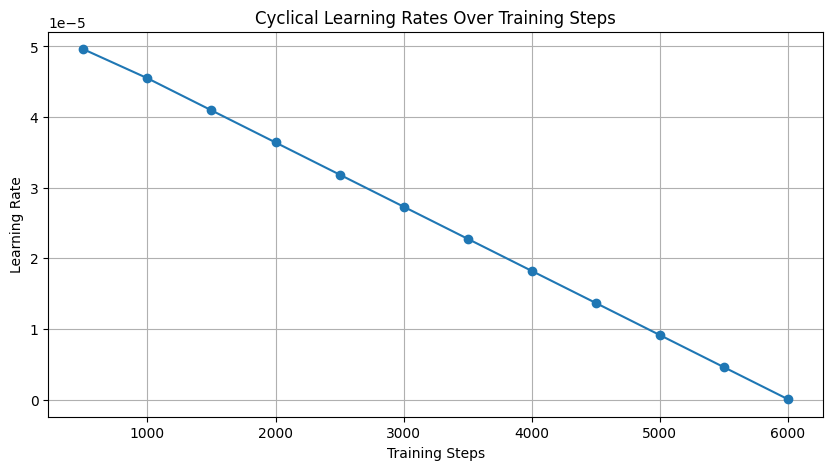

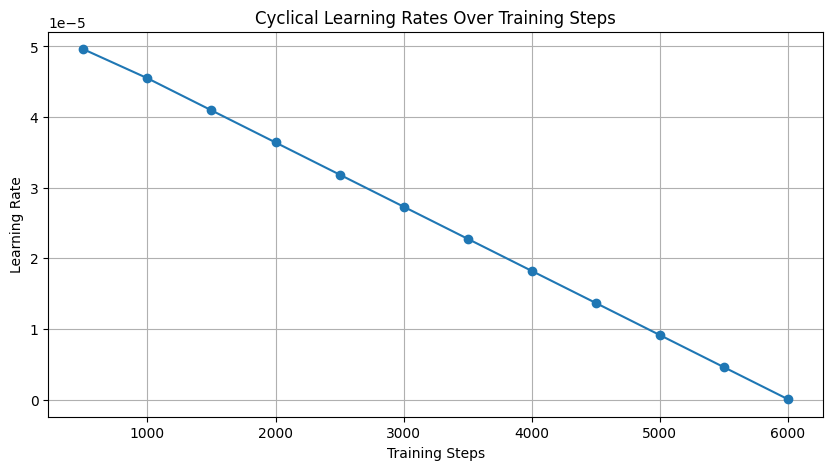

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, marker='o')
plt.title('Cyclical Learning Rates Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

# Demo

In [ ]:
from transformers import AutoTokenizer
import torch

checkpoint = "sshleifer/distilbart-cnn-12-6"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
# to load model
model = torch.load('/content/drive/MyDrive/myModel/text-summarization/ts-4.pth', map_location=torch.device('cpu'))

In [ ]:
print(torch.cuda.is_available())
print("Model parameters device:", next(model.parameters()).device)

True

In [ ]:
def generate(input):
    flex_max_length = input.split(" ")

    # set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    # tokenize input
    input_ids = tokenizer.encode(input, return_tensors="pt", padding="max_length", truncation=True, max_length=round(len(flex_max_length)*(4/10)))
    input_ids = input_ids.to(device)
    # Generate the summary
    summary_ids = model.generate(input_ids)
    # Decode the generated summary
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f"\nYour generated summary:\n{generated_summary}")

In [ ]:
generate(str(input("input your article: ")))

input your article: Jastin Suriono, [13/12/2023 20:36] Thai police are taking legal action against a Chinese social media influencer for allegedly flouting visa rules, days after she came under fire for a video she made that portrayed a popular Bangkok nightlife district as being unsafe for women. Police Major General Phanthana Nutchanart, deputy chief of Thailand’s Immigration Bureau, told CNN that Ziyu Wang, a Chinese national who has been traveling around Thailand, was found to be selling goods online while on Thai soil – breaking visa laws. Wang, 28, had arrived in Bangkok on November 2 on a tourist visa, Thai police told CNN. “She worked here without a work permit and police are processing her,” Nutchanart said. “We have summoned her and informed her of the charge of violating (her) visa.” The case comes at a tricky time for Thailand as it tries to woo back Chinese tourists after the Covid-19 pandemic. It also highlights how social media influencers can find themselves in legal ho

In [ ]:
generate(str(input("input your article: ")))

input your article: China and Vietnam, centuries-old rivals with longstanding tensions over conflicting claims in the South China Sea, on Tuesday agreed to build trust and expand cooperation — just months after Hanoi upgraded its relations with Washington. At a summit in Hanoi, Chinese leader Xi Jinping and Vietnamese Communist Party chief Nguyen Phu Trong called for the bolstering of their strategic relationship and agreed to cooperate on issues ranging from maritime patrols to trade and crime prevention, in what Chinese state media hailed as a “new positioning of relations” between the Communist-ruled neighbors. The two leaders also pledged that their countries would build a community with a “shared future” — using a key Xi phraseology, according to statements released by both sides’ official media following their meeting in Hanoi Tuesday. Trong called Xi’s two-day visit to the capital “a new historic milestone,” which would take the relations between the two Communist parties and co

In [ ]:
1+1

2

China and Vietnam, centuries-old rivals with longstanding tensions over conflicting claims in the South China Sea, on Tuesday agreed to build trust and expand cooperation — just months after Hanoi upgraded its relations with Washington. At a summit in Hanoi, Chinese leader Xi Jinping and Vietnamese Communist Party chief Nguyen Phu Trong called for the bolstering of their strategic relationship and agreed to cooperate on issues ranging from maritime patrols to trade and crime prevention, in what Chinese state media hailed as a “new positioning of relations” between the Communist-ruled neighbors.
The two leaders also pledged that their countries would build a community with a “shared future” — using a key Xi phraseology, according to statements released by both sides’ official media following their meeting in Hanoi Tuesday. Trong called Xi’s two-day visit to the capital “a new historic milestone,” which would take the relations between the two Communist parties and countries “to a new height,” according to state-run Vietnam News Agency (VNA). The two sides agreed to “unceasingly consolidate political trust,” and build ties “on the basis of mutual respect, equal and win-win cooperation” with respect for each other’s “independence, sovereignty and territorial integrity,” the Vietnamese report said. A Chinese account of the meeting released Tuesday also stressed bolstering trust but made no mention of sovereignty and territorial integrity in relation to their ties.

\


30% dari article\
Your generated summary:
Chinese and Vietnamese leaders meet in Hanoi to discuss building trust and expanding cooperation.
Chinese state media hailed the meeting as a "new positioning of relations" between the Communist-run neighbors.
The two sides agreed to strengthen their relations on the basis of mutual respect and equality.
\
\
\
50% dari article\
China and Vietnam have agreed to build trust and expand cooperation.
Chinese state media hailed the "new positioning of relations" between the two countries.
The two called for the bolstering of their strategic relationship.
It comes just months after Hanoi upgraded its relations with Washington.

